In [1]:
import pandas as pd
import logging
import os
import io
import types
import altair as alt

In [2]:
%run MakeNBImportAvailable.ipynb

In [3]:
import knmi_gn_001 as gethdd

importing Jupyter notebook from knmi_gn_001.ipynb


In [4]:
log_format = "%(asctime)s::%(levelname)s::%(name)s::"\
             "%(filename)s::%(lineno)d::%(message)s"
logging.basicConfig(filename='Anomaly_detection.log', level='DEBUG', format=log_format)

In [5]:
logging.info("read data from file")
fn = "dagelijks_energieverbuik.csv"
df_hist = pd.read_csv(fn, parse_dates=['dy'],
                      index_col = ['Unnamed: 0'])

In [6]:
df_hist.tail()

,variable,dy,verbruik,yr,month,day,year,normaldate,cumul,FJ_mnth,FJ_yr,FJ_cumul,subtractyears,FJ_normaldate,period,daysago
31,gas,2022-12-15,11.880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,gas,2022-12-16,10.766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,gas,2022-12-17,7.529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,gas,2022-12-18,10.246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,gas,2022-12-19,6.076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def add_calendarinfo(df,firstmonth):
    df['yr'] = df['dy'].dt.year
    df['month'] =df['dy'].dt.month
    df['day']=df['dy'].dt.day
    df['year'] = 2024
    df['normaldate'] =pd.to_datetime(df[['year','month', 'day']],format='%Y-%m-%d')
    logging.info("calendar info added to df")
    
    df['cumul'] = df[['variable','dy','verbruik','yr']].groupby(['variable','yr']).cumsum() 
    
    # Factuur jaar FJ
    # corrigeer zodat eerste factuurmaand nr 1 wordt
    df['FJ_mnth'] = df['month']-(firstmonth-1)
    # corrigeer number maand in het jaar naar nummer maand in factuur jaar
    # als eerste maand 10 is, dan maand september wordt 12 : 9+(12-(10-1)) 
    df.loc[df['month']<firstmonth,['FJ_mnth']] = df.loc[df['month']<firstmonth,'month'].apply(lambda x: x+ (12-(firstmonth-1)))
    df['FJ_yr'] = df['yr']
    df.loc[df['month']>=firstmonth,['FJ_yr']] = df.loc[df['month']>=firstmonth,'yr'].apply(lambda x: x+1)
    df['FJ_cumul'] = df[['variable','FJ_yr','dy','verbruik']].groupby(['variable','FJ_yr']).cumsum()
    
    df['subtractyears'] = 0
    df.loc[df['month']>=firstmonth,['subtractyears']] = 1
    df['FJ_normaldate'] = df.apply(lambda x: x['normaldate']-pd.offsets.DateOffset(years=x['subtractyears']),axis=1)
    
    

        # Mathijs (2020-08-01)
    # Covid (thuiswerken 2020-03-01)
    # Vloerisolatie (2022-02-25)
    df['period']='1.pre-Covid'
    df.loc[df['dy']>='2020-03-01','period']='2.Covid'
    df.loc[df['dy']>='2021-09-01','period']='3.Mathijs'
    df.loc[df['dy']>='2022-02-26','period']='4.VloerIsolatie'
    df.loc[df['dy']>='2022-06-12','period']='5.ExtraDakIsolatie'

    
    
    df['daysago'] = df['dy'].max() - df['dy'] 
    df['daysago'] = df['daysago'].dt.days 
    
    return df

In [8]:
firstmonth = 6
gas = add_calendarinfo(df_hist,firstmonth)

In [9]:
gas = gas[gas['variable']=='gas']

In [10]:
periods = gas['period'].unique()

In [11]:
gas = gas[gas['period'].isin(periods[1:3])]

In [12]:
gas.shape

(700, 16)

In [13]:
gas = gas[gas['verbruik']>1.3]

In [14]:
gas.shape

(393, 16)

In [15]:
# def get_weatherdata(firstmonth):
#     df = gethdd.retrieveHDD()
#     df['month'] = df.index.month
#     df['yr'] = df.index.year
#     df['FJ_mnth'] = df['month']-(firstmonth-1)
#     # df.loc[df['month']<10,['FJ_mnth']] = df.loc[df['month']<10,'month'].apply(lambda x: x+3)
#     # als eerste maand 10 is, dan maand september wordt 12 : 9+(12-(10-1))
#     df.loc[df['month']<firstmonth,['FJ_mnth']] = df.loc[df['month']<firstmonth,'month'].apply(lambda x: x+ (12-(firstmonth-1)))
#     df['FJ_yr'] = df['yr']
#     df.loc[df['month']>=firstmonth,['FJ_yr']] = df.loc[df['month']>=firstmonth,'yr'].apply(lambda x: x+1)
    
#     df['FJ_cumul_hdd'] = df[['HDD','FJ_yr']].groupby(['FJ_yr']).cumsum()
#     df['Teff'] = df['TG']*1/10 - 2/3*df['FG']*1/10
    
#     df['day']=df.index.day
#     df['year'] = 2024
#     df['normaldate'] =pd.to_datetime(df[['year','month', 'day']],format='%Y-%m-%d')
    
#     df['subtractyears'] = 0
#     df.loc[df['month']>=firstmonth,['subtractyears']] = 1
#     df['FJ_normaldate'] = df.apply(lambda x: x['normaldate']-pd.offsets.DateOffset(years=x['subtractyears']),axis=1)
    
    
    
#     return df

In [16]:
df_hdd = gethdd.retrieveHDD()
df_hdd

read the csv file with knmi data  knmi_data.csv
last data point in csv file:  2022-12-18 00:00:00
The current time is : 2022-12-19 19:31:31.422635
The number of days since last datapoint is : 1
KNMI last datapoint is : 2022-12-18 00:00:00
Current time : 2022-12-19 19:31:31.463080
Elapsed time since  [hours] :  43
Nr rows to add :  1
              SQ      Q    DR    TG    FG   RH        HDD       dow
datetime                                                           
2022-12-15  55.0  393.0   7.0 -23.0  20.0  3.0  17.633333  Thursday
2022-12-16   0.0   56.0   0.0  -8.0  12.0 -1.0  15.600000    Friday
2022-12-17   2.0  175.0   0.0 -17.0  27.0  0.0  17.500000  Saturday
2022-12-18  13.0  181.0  19.0 -28.0  28.0  4.0  18.666667    Sunday
2022-12-19   0.0    0.0   0.0   0.0   0.0  0.0  14.000000    Monday


,SQ,Q,DR,TG,FG,RH,HDD,dow
datetime,,,,,,,,
1989-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday
1989-10-13,NaN,NaN,NaN,130.0,46.0,NaN,4.066667,Friday
1989-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday
1989-10-19,NaN,NaN,NaN,130.0,21.0,NaN,2.400000,Thursday
1989-10-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday
...,...,...,...,...,...,...,...,...
2022-12-15,55.0,393.0,7.0,-23.0,20.0,3.0,17.633333,Thursday
2022-12-16,0.0,56.0,0.0,-8.0,12.0,-1.0,15.600000,Friday
2022-12-17,2.0,175.0,0.0,-17.0,27.0,0.0,17.500000,Saturday


# DD is windrichting, nu nog niet meegenomen

In [17]:
def adddaysbeforeascolumn(nrdays,df):
    header = df.columns[0:6]
    header1 = [''.join([h,'min',str(nrdays)]) for h in header]
    
    df = df[header].shift(nrdays)
    df.columns = header1 
    
    return(df)
                      

In [18]:
df = pd.concat([df_hdd,adddaysbeforeascolumn(1,df_hdd)],axis=1)
df = pd.concat([df,adddaysbeforeascolumn(2,df_hdd)],axis=1)
df

,SQ,Q,DR,TG,FG,RH,HDD,dow,SQmin1,Qmin1,DRmin1,TGmin1,FGmin1,RHmin1,SQmin2,Qmin2,DRmin2,TGmin2,FGmin2,RHmin2
datetime,,,,,,,,,,,,,,,,,,,,
1989-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-10-13,NaN,NaN,NaN,130.0,46.0,NaN,4.066667,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,NaN,NaN,NaN,130.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-10-19,NaN,NaN,NaN,130.0,21.0,NaN,2.400000,Thursday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.0,46.0,NaN
1989-10-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday,NaN,NaN,NaN,130.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-15,55.0,393.0,7.0,-23.0,20.0,3.0,17.633333,Thursday,60.0,471.0,0.0,-60.0,8.0,0.0,57.0,417.0,0.0,-45.0,8.0,0.0
2022-12-16,0.0,56.0,0.0,-8.0,12.0,-1.0,15.600000,Friday,55.0,393.0,7.0,-23.0,20.0,3.0,60.0,471.0,0.0,-60.0,8.0,0.0
2022-12-17,2.0,175.0,0.0,-17.0,27.0,0.0,17.500000,Saturday,0.0,56.0,0.0,-8.0,12.0,-1.0,55.0,393.0,7.0,-23.0,20.0,3.0


In [19]:
df.columns

Index(['SQ', 'Q', 'DR', 'TG', 'FG', 'RH', 'HDD', 'dow', 'SQmin1', 'Qmin1',
       'DRmin1', 'TGmin1', 'FGmin1', 'RHmin1', 'SQmin2', 'Qmin2', 'DRmin2',
       'TGmin2', 'FGmin2', 'RHmin2'],
      dtype='object')

In [20]:
len(df.columns)

20

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
### integer mapping using LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['dow'])
# print(integer_encoded)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

### One hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# print(onehot_encoded)

In [22]:
dow = pd.DataFrame(data=onehot_encoded)
a = df['dow'].unique().tolist()
a.sort()
dow.columns = a

In [23]:
df = df.reset_index()
df = pd.concat([df,dow],axis=1)

In [24]:
df = df.set_index('datetime')

In [25]:
# for predict consumption  algorithm later on
lastweekweather = df.iloc[-7:]

In [26]:
df.columns

Index(['SQ', 'Q', 'DR', 'TG', 'FG', 'RH', 'HDD', 'dow', 'SQmin1', 'Qmin1',
       'DRmin1', 'TGmin1', 'FGmin1', 'RHmin1', 'SQmin2', 'Qmin2', 'DRmin2',
       'TGmin2', 'FGmin2', 'RHmin2', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [27]:
len(df.columns)

27

In [28]:
df = df[df.index.isin(gas['dy'])]

In [29]:
df.shape

(393, 27)

In [30]:
df=pd.merge(df, gas,
    right_on='dy',left_index=True,how='left')

In [31]:
df.columns

Index(['SQ', 'Q', 'DR', 'TG', 'FG', 'RH', 'HDD', 'dow', 'SQmin1', 'Qmin1',
       'DRmin1', 'TGmin1', 'FGmin1', 'RHmin1', 'SQmin2', 'Qmin2', 'DRmin2',
       'TGmin2', 'FGmin2', 'RHmin2', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'variable', 'dy', 'verbruik', 'yr',
       'month', 'day', 'year', 'normaldate', 'cumul', 'FJ_mnth', 'FJ_yr',
       'FJ_cumul', 'subtractyears', 'FJ_normaldate', 'period', 'daysago'],
      dtype='object')

In [32]:

source = df
color_gn = ['#D35400','#7D3C98', 'steelblue', 'chartreuse', '#F4D03F']

chart1 = alt.Chart(source).mark_point(clip=True).encode(
    x=alt.X('TG:Q',axis=alt.Axis(title='Gem Temp'),scale=alt.Scale(domain=(-150, 260))),
    y=alt.Y('verbruik',axis=alt.Axis(title='verbruik'),scale=alt.Scale(domain=(0, 20))),
    # fill='period:N',
    # fill=alt.Fill('period:N',scale=alt.Scale(scheme='dark2')),
    fill=alt.Fill('period:N',scale=alt.Scale(range=color_gn)),
    size=alt.Size('period',scale=alt.Scale(range=[50,200]))
).interactive().properties(width=600,height=400)

#
chart1 

alt.Chart(...)

In [33]:
# Identify the anomalies in the data

In [34]:
from sklearn.ensemble import IsolationForest

In [35]:
#https://medium.com/towards-data-science/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2

In [36]:
df.head()

,SQ,Q,DR,TG,FG,RH,HDD,dow,SQmin1,Qmin1,...,year,normaldate,cumul,FJ_mnth,FJ_yr,FJ_cumul,subtractyears,FJ_normaldate,period,daysago
781,43.0,713.0,0.0,67.0,55.0,0.0,10.966667,Sunday,32.0,614.0,...,2024,2024-03-01,445.524,10,2020,1065.023,0,2024-03-01,2.Covid,1023
782,0.0,316.0,67.0,55.0,27.0,70.0,10.300000,Monday,43.0,713.0,...,2024,2024-03-02,450.118,10,2020,1069.617,0,2024-03-02,2.Covid,1022
783,81.0,1100.0,6.0,48.0,34.0,6.0,11.466667,Tuesday,0.0,316.0,...,2024,2024-03-03,455.604,10,2020,1075.103,0,2024-03-03,2.Covid,1021
784,31.0,708.0,6.0,48.0,24.0,10.0,10.800000,Wednesday,81.0,1100.0,...,2024,2024-03-04,461.585,10,2020,1081.084,0,2024-03-04,2.Covid,1020
785,8.0,453.0,64.0,54.0,38.0,69.0,11.133333,Thursday,31.0,708.0,...,2024,2024-03-05,467.425,10,2020,1086.924,0,2024-03-05,2.Covid,1019


In [37]:
to_model_columns = ['HDD','verbruik']

In [38]:
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=6972, verbose=0)
clf.fit(df[to_model_columns])

/home/gert/env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.12, n_jobs=-1, random_state=6972)

In [39]:
pred = clf.predict(df[to_model_columns])
df['anomaly']=pred

In [40]:
df

,SQ,Q,DR,TG,FG,RH,HDD,dow,SQmin1,Qmin1,...,normaldate,cumul,FJ_mnth,FJ_yr,FJ_cumul,subtractyears,FJ_normaldate,period,daysago,anomaly
781,43.0,713.0,0.0,67.0,55.0,0.0,10.966667,Sunday,32.0,614.0,...,2024-03-01,445.524,10,2020,1065.023,0,2024-03-01,2.Covid,1023,1
782,0.0,316.0,67.0,55.0,27.0,70.0,10.300000,Monday,43.0,713.0,...,2024-03-02,450.118,10,2020,1069.617,0,2024-03-02,2.Covid,1022,1
783,81.0,1100.0,6.0,48.0,34.0,6.0,11.466667,Tuesday,0.0,316.0,...,2024-03-03,455.604,10,2020,1075.103,0,2024-03-03,2.Covid,1021,1
784,31.0,708.0,6.0,48.0,24.0,10.0,10.800000,Wednesday,81.0,1100.0,...,2024-03-04,461.585,10,2020,1081.084,0,2024-03-04,2.Covid,1020,1
785,8.0,453.0,64.0,54.0,38.0,69.0,11.133333,Thursday,31.0,708.0,...,2024-03-05,467.425,10,2020,1086.924,0,2024-03-05,2.Covid,1019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,63.0,406.0,0.0,0.0,12.0,0.0,14.800000,Monday,40.0,313.0,...,2024-01-10,88.127,8,2022,739.731,0,2024-01-10,3.Mathijs,343,-1
246,52.0,370.0,0.0,8.0,22.0,-1.0,14.666667,Tuesday,63.0,406.0,...,2024-01-11,100.892,8,2022,752.496,0,2024-01-11,3.Mathijs,342,1
247,10.0,217.0,0.0,37.0,20.0,0.0,11.633333,Wednesday,52.0,370.0,...,2024-01-12,111.996,8,2022,763.600,0,2024-01-12,3.Mathijs,341,1
248,0.0,107.0,0.0,42.0,33.0,0.0,12.000000,Thursday,10.0,217.0,...,2024-01-13,121.016,8,2022,772.620,0,2024-01-13,3.Mathijs,340,1


In [41]:
source = df

color_gn = ['#D35400','#7D3C98', 'steelblue', 'chartreuse', '#F4D03F']

chart1 = alt.Chart(source).mark_point(clip=True).encode(
    x=alt.X('HDD:Q',axis=alt.Axis(title='Gem Temp'),scale=alt.Scale(domain=(0, 25))),
    y=alt.Y('verbruik',axis=alt.Axis(title='verbruik'),scale=alt.Scale(domain=(0, 20))),
    fill=alt.Fill('anomaly:N',scale=alt.Scale(range=color_gn[2:])),
     size=alt.Size('anomaly',scale=alt.Scale(range=[200,50]))
).interactive().properties(width=600,height=400)

#
chart1 

alt.Chart(...)

In [42]:
cols = ['SQ', 'Q', 'DR', 'TG', 'FG', 'RH', 'SQmin1', 'Qmin1',
       'DRmin1', 'TGmin1', 'FGmin1', 'RHmin1', 'SQmin2', 'Qmin2', 'DRmin2',
       'TGmin2', 'FGmin2', 'RHmin2', 'verbruik']

In [43]:
# to_model_columns = df.columns[[0,1,2,3,4,5,
#                               8,9,10,11,12,13,
#                               14,15,16,17,18,19,
#                               22]]

In [44]:
to_model_columns = cols

In [45]:
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=6972, verbose=0)
clf.fit(df[to_model_columns])

/home/gert/env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.12, n_jobs=-1, random_state=6972)

In [46]:
pred = clf.predict(df[to_model_columns])
df['anomaly2'] = pred

In [47]:
source = df

color_gn = ['#D35400','#7D3C98', 'steelblue', 'chartreuse', '#F4D03F']

chart1 = alt.Chart(source).mark_point(clip=True).encode(
    x=alt.X('HDD:Q',axis=alt.Axis(title='HDD'),scale=alt.Scale(domain=(0, 25))),
    y=alt.Y('verbruik',axis=alt.Axis(title='verbruik'),scale=alt.Scale(domain=(0, 20))),
    fill=alt.Fill('anomaly2:N',scale=alt.Scale(range=color_gn[2:])),
     size=alt.Size('anomaly2',scale=alt.Scale(range=[200,50]))
).interactive().properties(width=600,height=400)

#
chart1 

alt.Chart(...)

In [48]:
dow.columns

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

In [49]:
cols2 = cols + dow.columns.tolist()

In [50]:
to_model_columns = cols2

In [51]:
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=6972, verbose=0)
clf.fit(df[to_model_columns])

/home/gert/env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.12, n_jobs=-1, random_state=6972)

In [52]:
pred = clf.predict(df[to_model_columns])
df['anomaly3'] = pred

In [53]:
source = df

color_gn = ['#D35400','#7D3C98', 'steelblue', 'chartreuse', '#F4D03F']

chart1 = alt.Chart(source).mark_point(clip=True).encode(
    x=alt.X('HDD:Q',axis=alt.Axis(title='HDD'),scale=alt.Scale(domain=(0, 25))),
    y=alt.Y('verbruik',axis=alt.Axis(title='verbruik'),scale=alt.Scale(domain=(0, 20))),
    fill=alt.Fill('anomaly3:N',scale=alt.Scale(range=color_gn[2:])),
     size=alt.Size('anomaly3',scale=alt.Scale(range=[200,50]))
).interactive().properties(width=600,height=400)

#
chart1 

alt.Chart(...)

In [54]:
source = df

color_gn = ['#D35400','#7D3C98', 'steelblue', 'chartreuse', '#F4D03F']

chart1 = alt.Chart(source).mark_point(clip=True).encode(
    x=alt.X('dow',axis=alt.Axis(title='HDD')),
    y=alt.Y('anomaly3',axis=alt.Axis(title='verbruik'),scale=alt.Scale(domain=(-2, 2))),
    fill=alt.Fill('anomaly3:N',scale=alt.Scale(range=color_gn[2:])),
     size=alt.Size('verbruik',scale=alt.Scale(range=[100,250]))
).interactive().properties(width=600,height=400)

#
chart1 

alt.Chart(...)

In [55]:
# df = df.reset_index()

In [56]:
outliers=df.loc[df['anomaly2']==-1]
outlier_index=list(outliers.index)

In [57]:
# PCA into 3 dimensions

IndexError: index 790 is out of bounds for axis 0 with size 393

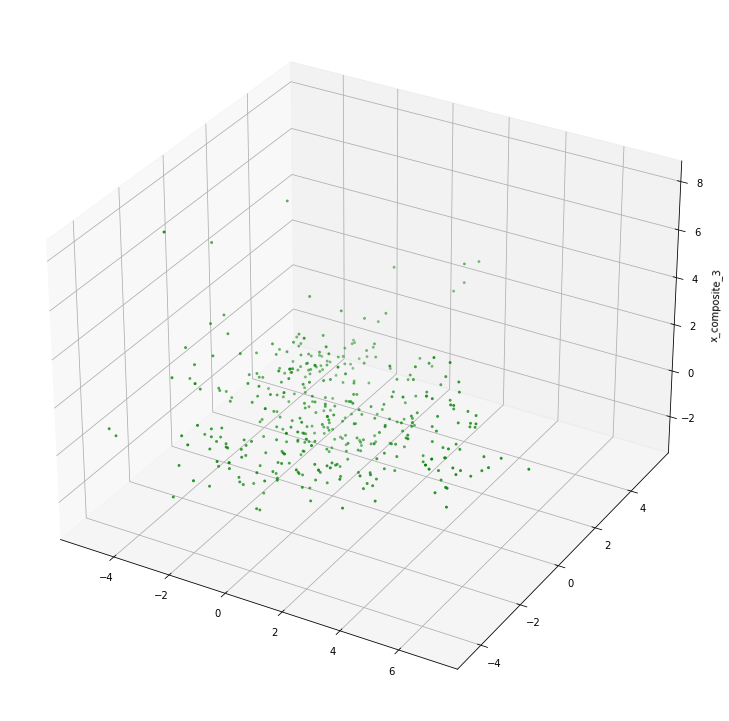

In [58]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(df[to_model_columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [59]:
# https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

In [60]:
# remove the outliers
df = df[df['anomaly2']==1]

In [61]:
df.shape

(345, 46)

In [62]:
df

,SQ,Q,DR,TG,FG,RH,HDD,dow,SQmin1,Qmin1,...,FJ_mnth,FJ_yr,FJ_cumul,subtractyears,FJ_normaldate,period,daysago,anomaly,anomaly2,anomaly3
781,43.0,713.0,0.0,67.0,55.0,0.0,10.966667,Sunday,32.0,614.0,...,10,2020,1065.023,0,2024-03-01,2.Covid,1023,1,1,1
782,0.0,316.0,67.0,55.0,27.0,70.0,10.300000,Monday,43.0,713.0,...,10,2020,1069.617,0,2024-03-02,2.Covid,1022,1,1,1
783,81.0,1100.0,6.0,48.0,34.0,6.0,11.466667,Tuesday,0.0,316.0,...,10,2020,1075.103,0,2024-03-03,2.Covid,1021,1,1,1
784,31.0,708.0,6.0,48.0,24.0,10.0,10.800000,Wednesday,81.0,1100.0,...,10,2020,1081.084,0,2024-03-04,2.Covid,1020,1,1,1
785,8.0,453.0,64.0,54.0,38.0,69.0,11.133333,Thursday,31.0,708.0,...,10,2020,1086.924,0,2024-03-05,2.Covid,1019,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,40.0,313.0,30.0,44.0,38.0,42.0,12.133333,Sunday,18.0,209.0,...,8,2022,725.319,0,2024-01-09,3.Mathijs,344,1,1,1
245,63.0,406.0,0.0,0.0,12.0,0.0,14.800000,Monday,40.0,313.0,...,8,2022,739.731,0,2024-01-10,3.Mathijs,343,-1,1,1
246,52.0,370.0,0.0,8.0,22.0,-1.0,14.666667,Tuesday,63.0,406.0,...,8,2022,752.496,0,2024-01-11,3.Mathijs,342,1,1,1
247,10.0,217.0,0.0,37.0,20.0,0.0,11.633333,Wednesday,52.0,370.0,...,8,2022,763.600,0,2024-01-12,3.Mathijs,341,1,1,1


# Regression: Lasso and Ridge

In [63]:
import numpy as np

In [64]:
df.columns

Index(['SQ', 'Q', 'DR', 'TG', 'FG', 'RH', 'HDD', 'dow', 'SQmin1', 'Qmin1',
       'DRmin1', 'TGmin1', 'FGmin1', 'RHmin1', 'SQmin2', 'Qmin2', 'DRmin2',
       'TGmin2', 'FGmin2', 'RHmin2', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'variable', 'dy', 'verbruik', 'yr',
       'month', 'day', 'year', 'normaldate', 'cumul', 'FJ_mnth', 'FJ_yr',
       'FJ_cumul', 'subtractyears', 'FJ_normaldate', 'period', 'daysago',
       'anomaly', 'anomaly2', 'anomaly3'],
      dtype='object')

In [65]:
y=df['verbruik']

In [66]:
columnstodrop = ['variable','dy','yr','dow','HDD',
       'month', 'day', 'year', 'normaldate', 'cumul', 'FJ_mnth', 'FJ_yr',
       'FJ_cumul', 'subtractyears', 'FJ_normaldate', 'period', 'daysago',
                 'anomaly', 'anomaly2', 'anomaly3','verbruik']

In [67]:
X = df.drop(columnstodrop,axis=1)

In [68]:
# convert to numpy array
X = np.array(X)
y = np.array(y)

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=6972)
print(X_train.shape)
print(X_test.shape)

(276, 25)
(69, 25)


In [70]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
# y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
# y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

scores = cross_val_score(LinearRegression(), X_train, y_train, cv=10)
cross_val_score_LR = np.mean(scores)
print('the average performance on the training set of the LR model with cross validation is '+str(cross_val_score_LR))
print(scores)

the average performance on the training set of the LR model with cross validation is 0.44081454611772697
[ 0.5318703  -0.00108594  0.15981501  0.38228589  0.73501418  0.21682418
  0.53897229  0.51281407  0.71399442  0.61764106]


In [72]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

param_grid_ridge = {'alpha': np.logspace(-6, 6)}
print(param_grid_ridge)

{'alpha': array([1.00000000e-06, 1.75751062e-06, 3.08884360e-06, 5.42867544e-06,
       9.54095476e-06, 1.67683294e-05, 2.94705170e-05, 5.17947468e-05,
       9.10298178e-05, 1.59985872e-04, 2.81176870e-04, 4.94171336e-04,
       8.68511374e-04, 1.52641797e-03, 2.68269580e-03, 4.71486636e-03,
       8.28642773e-03, 1.45634848e-02, 2.55954792e-02, 4.49843267e-02,
       7.90604321e-02, 1.38949549e-01, 2.44205309e-01, 4.29193426e-01,
       7.54312006e-01, 1.32571137e+00, 2.32995181e+00, 4.09491506e+00,
       7.19685673e+00, 1.26485522e+01, 2.22299648e+01, 3.90693994e+01,
       6.86648845e+01, 1.20679264e+02, 2.12095089e+02, 3.72759372e+02,
       6.55128557e+02, 1.15139540e+03, 2.02358965e+03, 3.55648031e+03,
       6.25055193e+03, 1.09854114e+04, 1.93069773e+04, 3.39322177e+04,
       5.96362332e+04, 1.04811313e+05, 1.84206997e+05, 3.23745754e+05,
       5.68986603e+05, 1.00000000e+06])}


In [73]:
grid_ridge = GridSearchCV(Ridge(), param_grid_ridge, return_train_score=True, cv=10)
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-06, 1.75751062e-06, 3.08884360e-06, 5.42867544e-06,
       9.54095476e-06, 1.67683294e-05, 2.94705170e-05, 5.17947468e-05,
       9.10298178e-05, 1.59985872e-04, 2.81176870e-04, 4.94171336e-04,
       8.68511374e-04, 1.52641797e-03, 2.68269580e-03, 4.71486636e-03,
       8.28642773e-03, 1.45634848e-02, 2.55954792e-02, 4...
       7.19685673e+00, 1.26485522e+01, 2.22299648e+01, 3.90693994e+01,
       6.86648845e+01, 1.20679264e+02, 2.12095089e+02, 3.72759372e+02,
       6.55128557e+02, 1.15139540e+03, 2.02358965e+03, 3.55648031e+03,
       6.25055193e+03, 1.09854114e+04, 1.93069773e+04, 3.39322177e+04,
       5.96362332e+04, 1.04811313e+05, 1.84206997e+05, 3.23745754e+05,
       5.68986603e+05, 1.00000000e+06])},
             return_train_score=True)

In [74]:
print('Results for ridge:')
print(grid_ridge.best_params_)
print(grid_ridge.best_score_)

Results for ridge:
{'alpha': 120.67926406393264}
0.5327424716933292


In [75]:
from sklearn.pipeline import make_pipeline

In [76]:
param_grid_lasso = {'alpha': np.logspace(-6, 6)}
# grid_lasso = GridSearchCV(Lasso(normalize=True, max_iter=1e7), param_grid_lasso, return_train_score=True, cv=10)
grid_lasso = GridSearchCV(Lasso(max_iter=1e7), param_grid_lasso, return_train_score=True, cv=10)
grid_lasso.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Lasso(max_iter=10000000.0),
             param_grid={'alpha': array([1.00000000e-06, 1.75751062e-06, 3.08884360e-06, 5.42867544e-06,
       9.54095476e-06, 1.67683294e-05, 2.94705170e-05, 5.17947468e-05,
       9.10298178e-05, 1.59985872e-04, 2.81176870e-04, 4.94171336e-04,
       8.68511374e-04, 1.52641797e-03, 2.68269580e-03, 4.71486636e-03,
       8.28642773e-03, 1.45634848e-...
       7.19685673e+00, 1.26485522e+01, 2.22299648e+01, 3.90693994e+01,
       6.86648845e+01, 1.20679264e+02, 2.12095089e+02, 3.72759372e+02,
       6.55128557e+02, 1.15139540e+03, 2.02358965e+03, 3.55648031e+03,
       6.25055193e+03, 1.09854114e+04, 1.93069773e+04, 3.39322177e+04,
       5.96362332e+04, 1.04811313e+05, 1.84206997e+05, 3.23745754e+05,
       5.68986603e+05, 1.00000000e+06])},
             return_train_score=True)

In [77]:
print('Results for lasso:')
print(grid_lasso.best_params_)
print(grid_lasso.best_score_)

Results for lasso:
{'alpha': 0.07906043210907701}
0.5788660890043438


In [78]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 12)

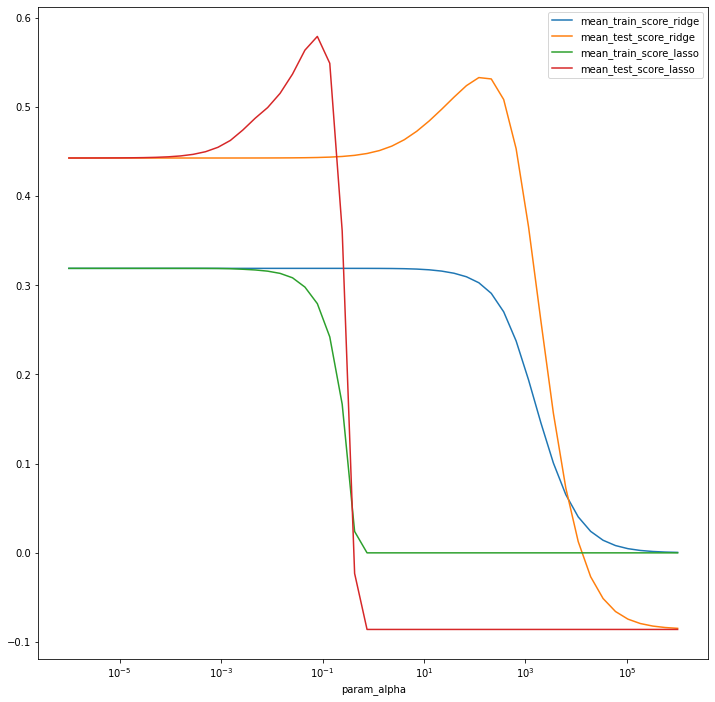

In [79]:
lasso_df=pd.DataFrame(grid_lasso.cv_results_)[['param_alpha', 'mean_train_score', 'mean_test_score']].copy()
lasso_df=lasso_df.rename(columns={'mean_train_score':'mean_train_score_lasso','mean_test_score':'mean_test_score_lasso' })

ridge_df =pd.DataFrame(grid_ridge.cv_results_)[['param_alpha', 'mean_train_score', 'mean_test_score']].copy()
ridge_df = ridge_df.rename(columns={'mean_train_score':'mean_train_score_ridge','mean_test_score':'mean_test_score_ridge'})

results_df = pd.merge(left=ridge_df, right=lasso_df)

results_df.plot('param_alpha', 'mean_train_score_ridge', )
results_df.plot('param_alpha', 'mean_test_score_ridge', ax=plt.gca())
results_df.plot('param_alpha', 'mean_train_score_lasso', ax=plt.gca())
results_df.plot('param_alpha', 'mean_test_score_lasso', ax=plt.gca())
plt.legend(loc='upper right')
plt.xscale("log")


In [80]:
ridge = grid_ridge.best_estimator_
print(str(ridge))

lasso = grid_lasso.best_estimator_
print(str(lasso))


pd.DataFrame({'variable':df.drop(columnstodrop,axis=1).columns,
             'ridge' : ridge.coef_,
             'lasso' : lasso.coef_})

Ridge(alpha=120.67926406393264)
Lasso(alpha=0.07906043210907701, max_iter=10000000.0)


,variable,ridge,lasso
0,SQ,-0.054027,-0.045673
1,Q,-0.047057,-0.079919
2,DR,0.013996,0.000000
3,TG,-0.176421,-0.269191
4,FG,-0.005501,-0.000000
5,RH,-0.020201,-0.000000
6,SQmin1,-0.036641,-0.000000
7,Qmin1,-0.032933,-0.004971
8,DRmin1,0.012260,0.000000
9,TGmin1,-0.110693,-0.004074


In [81]:
print('Numbers of coefficients equals to 0 for Ridge: '+str(np.sum(ridge.coef_ == 0)))
print('Numbers of coefficients equals to 0 for Lasso: '+str(np.sum(lasso.coef_ == 0)))

Numbers of coefficients equals to 0 for Ridge: 0
Numbers of coefficients equals to 0 for Lasso: 18


Text(0.5, 1.0, 'Ridge coefficients paths')

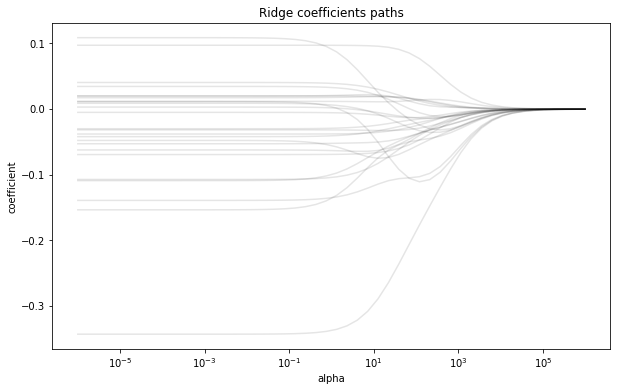

In [82]:
alphas = np.logspace(-6, 6)
coefs = []
zeros = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    zeros.append(np.sum(ridge.coef_ == 0))
plt.figure(figsize=(10,6))

plt.plot(alphas, coefs, c='k', alpha=.1)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("coefficient")
plt.title("Ridge coefficients paths")

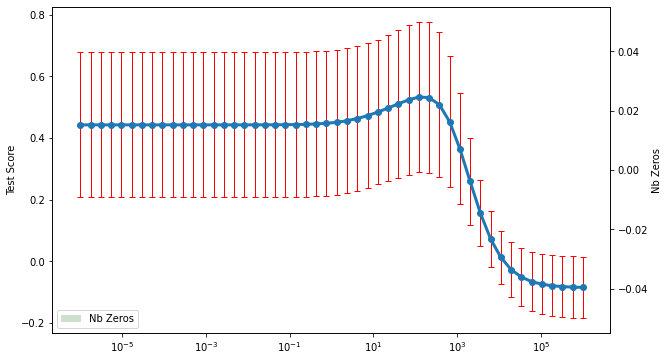

In [83]:
ridge_df=pd.DataFrame(grid_ridge.cv_results_)[['param_alpha', 'mean_test_score', 'std_test_score']].copy()

results_df = ridge_df

plt.figure(figsize=(10,6))

ax = plt.gca()
ax.errorbar(data=ridge_df, x='param_alpha', y='mean_test_score', yerr='std_test_score', 
            linewidth=3, elinewidth=1, ecolor='red', capsize=3, marker='o')
ax.set_ylabel("Test Score")

ax2 = ax.twinx()
ax2.bar(x=alphas, height=zeros, width=alphas / 4, label='Nb Zeros', color='darkgreen', alpha=0.2)
ax2.set_ylabel("Nb Zeros")

plt.xscale("log")
plt.legend(loc='lower left')

Text(0.5, 1.0, 'Lasso coefficients paths')

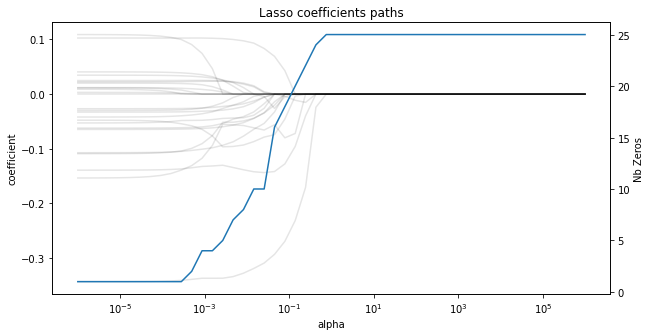

In [84]:
alphas = np.logspace(-6, 6)
coefs = []
zeros = []
for a in alphas:
    # lasso = Lasso(normalize=True, max_iter=1e7, alpha=a)
    lasso = Lasso( max_iter=1e7, alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    zeros.append(np.sum(lasso.coef_ == 0))

plt.figure(figsize=(10,5))

ax = plt.gca()
ax.plot(alphas, coefs, c='k', alpha=.1)
ax.set_ylabel("coefficient")

ax2 = ax.twinx()
ax2.plot(alphas, zeros)
ax2.set_ylabel("Nb Zeros")

ax.set_xscale("log")
ax.set_xlabel("alpha")
ax.set_title("Lasso coefficients paths")

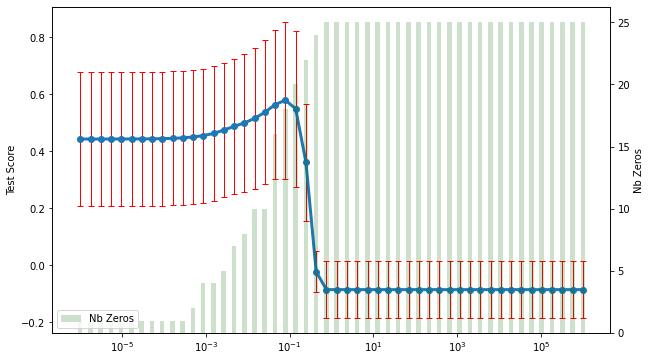

In [85]:
lasso_df=pd.DataFrame(grid_lasso.cv_results_)[['param_alpha', 'mean_test_score', 'std_test_score']].copy()

results_df = lasso_df

plt.figure(figsize=(10,6))

ax = plt.gca()
ax.errorbar(data=lasso_df, x='param_alpha', y='mean_test_score', yerr='std_test_score', 
            linewidth=3, elinewidth=1, ecolor='red', capsize=3, marker='o')
ax.set_ylabel("Test Score")

ax2 = ax.twinx()
ax2.bar(x=alphas, height=zeros, width=alphas / 4, label='Nb Zeros', color='darkgreen', alpha=0.2)
ax2.set_ylabel("Nb Zeros")

plt.xscale("log")
plt.legend(loc='lower left')

In [86]:
y_predict_l = scaler_y.inverse_transform(grid_lasso.predict(X_test).reshape(-1,1))
y_predict_l = [item for sublist in y_predict_l for item in sublist]
y_predict_r = scaler_y.inverse_transform(grid_ridge.predict(X_test).reshape(-1,1))
y_predict_r = [item for sublist in y_predict_r for item in sublist]

In [87]:
y_new_inverse = scaler_y.inverse_transform(y_test.reshape(-1,1))
y_new_inverse = [item for sublist in y_new_inverse for item in sublist]

In [88]:
compare = pd.DataFrame({'predict_lasso' : y_predict_l,
                        'predict_ridge' : y_predict_r,
                        'y_orig' : y_new_inverse})
compare                       

,predict_lasso,predict_ridge,y_orig
0,2.417108,1.659189,1.610
1,7.404852,4.526972,6.846
2,3.598404,3.807631,3.872
3,2.703743,1.853799,2.009
4,8.175184,6.991958,5.141
...,...,...,...
64,5.366886,4.940780,2.908
65,6.983818,7.310598,7.310
66,7.104381,8.606670,7.322
67,5.731642,5.393498,2.539


In [89]:
pw = 600
ph = 300
source = compare
y_max = compare.predict_lasso.max()
x_max = compare.y_orig.max()

chart_l = alt.Chart(source.reset_index(),title='predict vs orig').mark_point(clip=True,color='red').encode(
    y=alt.Y('predict_lasso:Q', scale = alt.Scale(domain=(0,x_max))),
    x=alt.X("y_orig:Q",  scale=alt.Scale(domain=(0, y_max)))
).properties(width=pw,height=ph)

chart_r = alt.Chart(source.reset_index(),title='predict vs orig').mark_point(clip=True,color='blue').encode(
    y=alt.Y('predict_ridge:Q', scale = alt.Scale(domain=(0,x_max))),
    x=alt.X("y_orig:Q",  scale=alt.Scale(domain=(0, y_max)))
).properties(width=pw,height=ph)


chart_lijn=alt.Chart(source.reset_index()).mark_line(clip=True,color='grey').encode(
    x=alt.X("y_orig:Q",  scale=alt.Scale(domain=(0, y_max))),
    y=alt.Y("y_orig:Q",  scale=alt.Scale(domain=(0, y_max)))
)

display(chart_l+chart_r+chart_lijn)

alt.LayerChart(...)

In [90]:
y_hist_ridge = scaler_y.inverse_transform(grid_ridge.predict(X_input).reshape(-1,1))
# y_hist_ridge = scaler_y.inverse_transform(grid_ridge.predict(X_input).shape(-1,1))
y_hist_lasso = scaler_y.inverse_transform(grid_lasso.predict(X_input).reshape(-1,1))

NameError: name 'X_input' is not defined

In [91]:
y_hist_ridge[y_hist_ridge<0] = 0
y_hist_lasso[y_hist_lasso<0] = 0

NameError: name 'y_hist_ridge' is not defined

In [92]:
df_hist['gas_est_rigde'] = y_hist_ridge
df_hist['gas_est_lasso'] = y_hist_lasso

NameError: name 'y_hist_ridge' is not defined

In [93]:
df_annual_est = df_hist[df_hist['HDD']>0].groupby([df_hist[df_hist['HDD']>0].index.year])[['gas_est_rigde','gas_est_lasso']].sum().reset_index()
df_annual_est = pd.melt(df_annual_est,id_vars='datetime')

KeyError: 'HDD'

In [ ]:
pw = 600
ph = 300
source = df_annual_est

chart = alt.Chart(source,title='Annual gas consumption heating').mark_line(clip=True).encode(
    y=alt.Y('value:Q'),
    x=alt.X("datetime:N"),
    color=alt.Color('variable:N')
).properties(width=pw,height=ph)

display(chart)

In [ ]:
df_annual_tbl = df_annual_est.pivot_table(values='value',columns='datetime',index='variable')
df_annual_tbl = round(df_annual_tbl,0)

In [ ]:
df_hist[['Q','RH','TG','FG','HDD','dow','gas_est_rigde','gas_est_lasso']].tail(10)

In [ ]:
df_annual_tbl

# Build regression model neural net


In [94]:
import numpy as np
# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [95]:


# split into X_train and X_test
# always split into X_train, X_test first THEN apply minmax scaler
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=6972)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# use minMax scaler
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

(276, 25) (69, 25) (276,) (69,)


In [96]:
# Neural Net modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

2022-12-19 19:33:20.810241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 19:33:21.325497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 19:33:21.325516: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-19 19:33:21.370973: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-19 19:33:22.361153: W tensorflow/stream_executor/platform/de

In [97]:
# nr of features
X_train.shape[1]

25

In [98]:
# build the model!
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              26000     
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 652,001
Trainable params: 652,001
Non-trainable params: 0
_________________________________________________________________


2022-12-19 19:33:23.132749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 19:33:23.133033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 19:33:23.133096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-19 19:33:23.133149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-19 19:33:23.133201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [99]:


# compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=5000,
                    batch_size=50,
                    verbose=1)

Epoch 1/5000
6/6 [==============================] - 1s 33ms/step - loss: 64.8091 - mae: 4.7426 - val_loss: 13.7246 - val_mae: 2.7713
Epoch 2/5000
6/6 [==============================] - 0s 11ms/step - loss: 46.2296 - mae: 3.3234 - val_loss: 28.1369 - val_mae: 4.4941
Epoch 3/5000
6/6 [==============================] - 0s 11ms/step - loss: 45.4359 - mae: 3.3329 - val_loss: 9.0063 - val_mae: 2.3976
Epoch 4/5000
6/6 [==============================] - 0s 11ms/step - loss: 39.2211 - mae: 2.7242 - val_loss: 9.8460 - val_mae: 2.4949
Epoch 5/5000
6/6 [==============================] - 0s 11ms/step - loss: 35.6834 - mae: 2.5624 - val_loss: 5.0478 - val_mae: 1.7831
Epoch 6/5000
6/6 [==============================] - 0s 11ms/step - loss: 37.4562 - mae: 2.5479 - val_loss: 16.8239 - val_mae: 3.4067
Epoch 7/5000
6/6 [==============================] - 0s 12ms/step - loss: 38.4291 - mae: 2.8738 - val_loss: 5.0775 - val_mae: 1.7985
Epoch 8/5000
6/6 [==============================] - 0s 12ms/step - loss: 

In [100]:
import matplotlib.pyplot as plt

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              26000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 250)               125250    
                                                                 
 dropout_2 (Dropout)         (None, 250)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

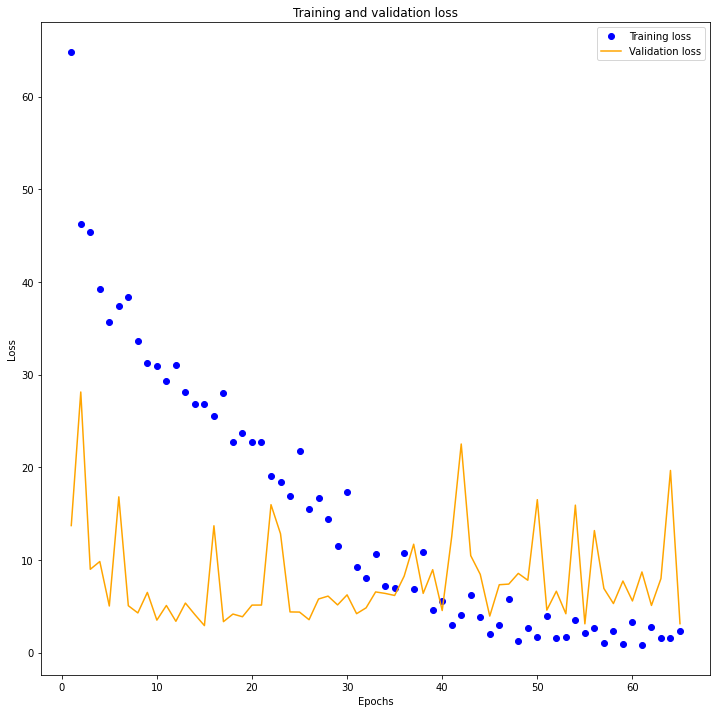

In [101]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')

from keras.layers import Dense, Dropout

# Insert the dropout layer
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dropout(0.2)) # specify a percentage between 0 and 0.5, or larger
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2)) # specify a percentage between 0 and 0.5, or larger
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2)) # specify a percentage between 0 and 0.5, or larger
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like
plt.ylabel('Loss')
plt.legend()
plt.show()

3/3 [==============================] - 0s 2ms/step


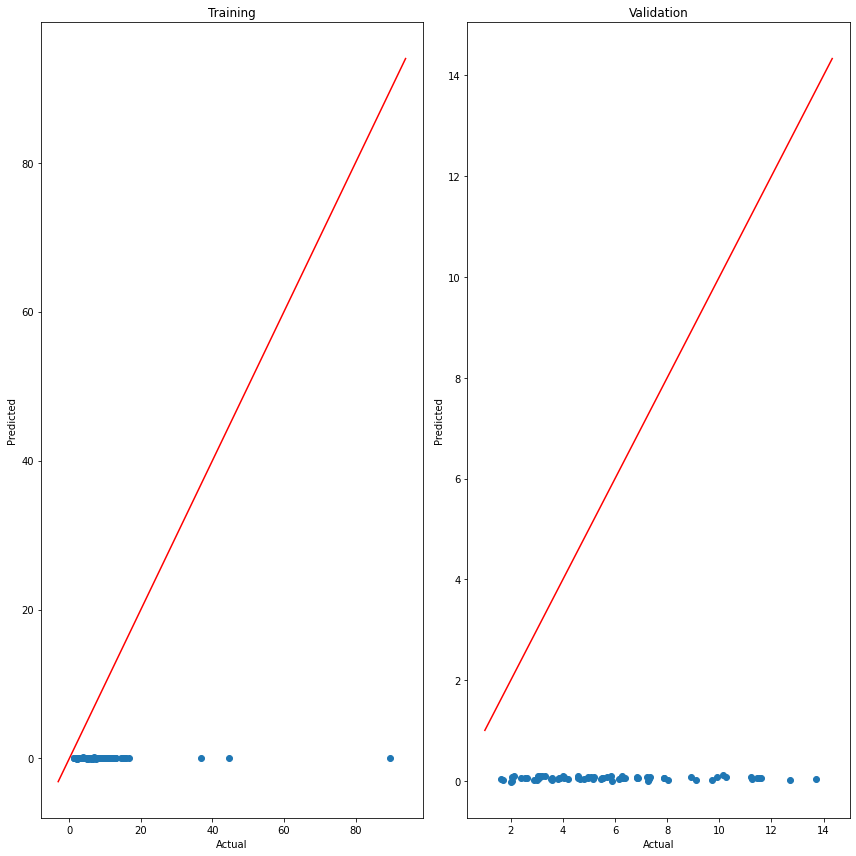

In [102]:
# scatterplot of actual vs. pred
# specify the dimensions 
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=model.predict(X_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=model.predict(X_test)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [103]:

# compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=5000,
                    batch_size=50,
                    verbose=1)

Epoch 1/5000
6/6 [==============================] - 1s 29ms/step - loss: 64.3827 - mae: 4.6409 - val_loss: 11.5829 - val_mae: 2.7394
Epoch 2/5000
6/6 [==============================] - 0s 12ms/step - loss: 48.4830 - mae: 3.5605 - val_loss: 9.7930 - val_mae: 2.4058
Epoch 3/5000
6/6 [==============================] - 0s 12ms/step - loss: 44.9022 - mae: 3.2247 - val_loss: 8.1124 - val_mae: 2.1844
Epoch 4/5000
6/6 [==============================] - 0s 12ms/step - loss: 40.5620 - mae: 2.7939 - val_loss: 9.7832 - val_mae: 2.4224
Epoch 5/5000
6/6 [==============================] - 0s 12ms/step - loss: 39.7586 - mae: 2.7026 - val_loss: 10.9965 - val_mae: 2.6242
Epoch 6/5000
6/6 [==============================] - 0s 12ms/step - loss: 36.9085 - mae: 2.5350 - val_loss: 6.5775 - val_mae: 1.9450
Epoch 7/5000
6/6 [==============================] - 0s 12ms/step - loss: 34.5706 - mae: 2.5132 - val_loss: 4.0992 - val_mae: 1.5729
Epoch 8/5000
6/6 [==============================] - 0s 12ms/step - loss: 3

3/3 [==============================] - 0s 2ms/step


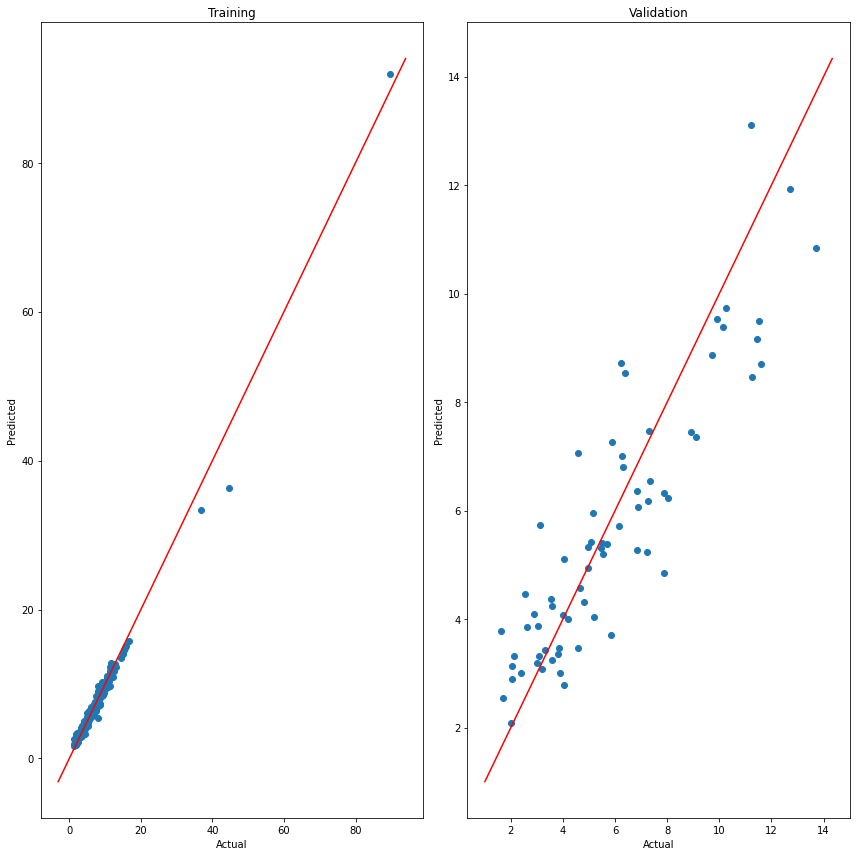

In [104]:
# scatterplot of actual vs. pred
# specify the dimensions 
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=model.predict(X_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=model.predict(X_test)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [105]:
# metrics
pred = model.predict(X_test)
pred

trainpreds = model.predict(X_train)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, trainpreds)) # train

9/9 [==============================] - 0s 2ms/step
0.4884976229633038


In [106]:
lastweekweather

,SQ,Q,DR,TG,FG,RH,HDD,dow,SQmin1,Qmin1,...,TGmin2,FGmin2,RHmin2,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-13,57.0,417.0,0.0,-45.0,8.0,0.0,19.033333,Tuesday,28.0,256.0,...,3.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-12-14,60.0,471.0,0.0,-60.0,8.0,0.0,20.533333,Wednesday,57.0,417.0,...,-13.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-12-15,55.0,393.0,7.0,-23.0,20.0,3.0,17.633333,Thursday,60.0,471.0,...,-45.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-12-16,0.0,56.0,0.0,-8.0,12.0,-1.0,15.600000,Friday,55.0,393.0,...,-60.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-17,2.0,175.0,0.0,-17.0,27.0,0.0,17.500000,Saturday,0.0,56.0,...,-23.0,20.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-12-18,13.0,181.0,19.0,-28.0,28.0,4.0,18.666667,Sunday,2.0,175.0,...,-8.0,12.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-12-19,0.0,0.0,0.0,0.0,0.0,0.0,14.000000,Monday,13.0,181.0,...,-17.0,27.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [107]:
# y_train

In [108]:
# trainpreds

In [109]:
lastweekweather.columns

Index(['SQ', 'Q', 'DR', 'TG', 'FG', 'RH', 'HDD', 'dow', 'SQmin1', 'Qmin1',
       'DRmin1', 'TGmin1', 'FGmin1', 'RHmin1', 'SQmin2', 'Qmin2', 'DRmin2',
       'TGmin2', 'FGmin2', 'RHmin2', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [110]:
pd.Series(columnstodrop)

0          variable
1                dy
2                yr
3               dow
4               HDD
5             month
6               day
7              year
8        normaldate
9             cumul
10          FJ_mnth
11            FJ_yr
12         FJ_cumul
13    subtractyears
14    FJ_normaldate
15           period
16          daysago
17          anomaly
18         anomaly2
19         anomaly3
20         verbruik
dtype: object

In [111]:
common_elements = np.intersect1d(lastweekweather.columns, columnstodrop)

In [112]:
common_elements

array(['HDD', 'dow'], dtype=object)

In [113]:
# lastweek
lastweekweather.drop(common_elements,axis=1,inplace=True)


# X_lw = min_max_scaler.transform()

In [114]:
X_lw = np.array(lastweekweather)

In [115]:
X_lw

array([[ 57., 417.,   0., -45.,   8.,   0.,  28., 256.,   0., -13.,  10.,
          0.,   0.,  44.,   0.,   3.,  15.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.],
       [ 60., 471.,   0., -60.,   8.,   0.,  57., 417.,   0., -45.,   8.,
          0.,  28., 256.,   0., -13.,  10.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.],
       [ 55., 393.,   7., -23.,  20.,   3.,  60., 471.,   0., -60.,   8.,
          0.,  57., 417.,   0., -45.,   8.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.],
       [  0.,  56.,   0.,  -8.,  12.,  -1.,  55., 393.,   7., -23.,  20.,
          3.,  60., 471.,   0., -60.,   8.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  2., 175.,   0., -17.,  27.,   0.,   0.,  56.,   0.,  -8.,  12.,
         -1.,  55., 393.,   7., -23.,  20.,   3.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.],
       [ 13., 181.,  19., -28.,  28.,   4.,   2., 175.,   0., -17.,  27.,
          0.,   0.,  56.,   0.,  -8.,  12.,  -1.,  

In [116]:
X_lw = min_max_scaler.transform(X_lw)

In [117]:
X_lw

array([[ 4.28571429e-01,  1.48222133e-01,  0.00000000e+00,
         7.89473684e-02,  6.45161290e-02,  6.09756098e-03,
         2.10526316e-01,  8.77926421e-02,  0.00000000e+00,
         1.01769912e-01,  8.00000000e-02,  5.43478261e-03,
         0.00000000e+00, -8.44238075e-04,  0.00000000e+00,
         3.52697095e-01,  1.46666667e-01,  5.43478261e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 4.51127820e-01,  1.69796245e-01,  0.00000000e+00,
         1.31578947e-02,  6.45161290e-02,  6.09756098e-03,
         4.28571429e-01,  1.55100334e-01,  0.00000000e+00,
        -3.98230088e-02,  5.33333333e-02,  5.43478261e-03,
         2.22222222e-01,  8.86449979e-02,  0.00000000e+00,
         2.86307054e-01,  8.00000000e-02,  5.43478261e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
    

In [118]:
pred_lw = model.predict(X_lw)
pred_lw

1/1 [==============================] - 0s 16ms/step


array([[19.12425 ],
       [17.278982],
       [14.314349],
       [14.186635],
       [30.41617 ],
       [13.711904],
       [16.326155]], dtype=float32)

In [119]:
sum(pred_lw)

array([125.35845], dtype=float32)

In [120]:
df_hist.iloc[-7:]

,variable,dy,verbruik,yr,month,day,year,normaldate,cumul,FJ_mnth,FJ_yr,FJ_cumul,subtractyears,FJ_normaldate,period,daysago
29,gas,2022-12-13,11.415,2022,12,13,2024,2024-12-13,1070.778,7,2023,292.341,1,2023-12-13,5.ExtraDakIsolatie,6
30,gas,2022-12-14,14.527,2022,12,14,2024,2024-12-14,1085.305,7,2023,306.868,1,2023-12-14,5.ExtraDakIsolatie,5
31,gas,2022-12-15,11.880,2022,12,15,2024,2024-12-15,1097.185,7,2023,318.748,1,2023-12-15,5.ExtraDakIsolatie,4
32,gas,2022-12-16,10.766,2022,12,16,2024,2024-12-16,1107.951,7,2023,329.514,1,2023-12-16,5.ExtraDakIsolatie,3
33,gas,2022-12-17,7.529,2022,12,17,2024,2024-12-17,1115.480,7,2023,337.043,1,2023-12-17,5.ExtraDakIsolatie,2
34,gas,2022-12-18,10.246,2022,12,18,2024,2024-12-18,1125.726,7,2023,347.289,1,2023-12-18,5.ExtraDakIsolatie,1
35,gas,2022-12-19,6.076,2022,12,19,2024,2024-12-19,1131.802,7,2023,353.365,1,2023-12-19,5.ExtraDakIsolatie,0


# Include Uncertainty
https://towardsdatascience.com/get-uncertainty-estimates-in-neural-networks-for-free-48f2edb82c8f

# Feature importance